In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
from torchmin import minimize
import scipy.stats as stats
from scipy.stats import chi2

In [12]:
# Parameter setzen
n_participants = 500
years = 10
effect_of_sex = 0.0
effect_of_age = -0.2

# random effects
var_intercept = 2
var_slope = 0.1

# fixed effects
weights = {'Systolic_BP': -0.1, 'Diastolic_BP': -0.1, 'Cholesterol': -0.2, 'Triglycerides': -0.2, 'BMI': -0.4, 'Creatinin': -0.1}


def simulate_data(num_participants):
    data = []
    # simulate data for each patient 
    for participant_id in range(1, n_participants + 1):
        age = np.random.randint(30, 61)  # patients are between 30 and 60
        gender = np.random.choice([0, 1])
        group = np.random.choice([0, 1])
        baseline_bp_sys = np.random.normal(120, 10)  # normal distributed systolic blood pressure vals
        baseline_bp_dia = np.random.normal(80, 10)  # normal ditributed diastolic blood pressure vals
        baseline_cholesterol = np.random.normal(200, 30)  # Cholesterin in mg/dL
        baseline_triglycerides = np.random.normal(150, 20)  # Triglyceride in mg/dL
        baseline_creatinin = np.random.normal(1,0.2) #creatinin in mg/dL
        baseline_bmi = np.random.normal(25, 4)  # BMI

        # randomly determine when the patient gets treatment 
        get_treatment = np.zeros((years), dtype=int)
        start_points = np.random.randint(3, years)
        for _ in range(years):
            get_treatment[start_points:] = 1

        # simulate random effects
        random_intercept = np.random.normal(0.0,np.sqrt(var_intercept))
        random_slope = np.random.normal(0.0, np.sqrt(var_slope))
        
        # simulate data for each year
        for year in range(years):
            # effect of the treatment
            if get_treatment[year] == 1:
                delta_bp = -2 * year  # treatment issues improvement of data  
                delta_cholesterol = -5 * year  # Cholesterin reduction of treatment
                delta_triglycerides = -3 * year  # Triglyceride reduction of treatment
                delta_creatinin = -0.08 * year
            else:
                delta_bp = -0.5 * year  # minimal natural improvement
                delta_cholesterol = -1 * year
                delta_triglycerides = -1 * year
                delta_creatinin = -0.01 * year
            
            # calculate the scores for each year
            sys_bp = baseline_bp_sys + delta_bp + np.random.normal(0, 5)
            dia_bp = baseline_bp_dia + delta_bp + np.random.normal(0, 5)
            cholesterol = max(100, baseline_cholesterol + delta_cholesterol + np.random.normal(0, 10))
            triglycerides = max(50, baseline_triglycerides + delta_triglycerides + np.random.normal(0, 5))
            creatinin = max(0.6, baseline_creatinin + delta_creatinin + np.random.normal(0, 0.1))

            bmi = baseline_bmi + np.random.normal(0, 0.5)  
            
            # calculate the test score 
            health_score = (100 + random_intercept +
                        weights['Systolic_BP'] * sys_bp +
                        weights['Diastolic_BP'] * dia_bp +
                        weights['Cholesterol'] * cholesterol +
                        weights['Triglycerides'] * triglycerides +
                        weights['BMI'] * bmi + 
                        weights['Creatinin'] * creatinin +
                        effect_of_sex * gender + 
                        effect_of_age * age +
                        random_slope * year)
            
            yearly_data = {
                'patient_id': participant_id,
                'Year': year,
                'Age': age,
                'Group': group,
                'Gender': gender,
                'Get_treatment': get_treatment[year] ,
                'Systolic_BP': sys_bp,
                'Diastolic_BP': dia_bp,
                'Cholesterol': cholesterol,
                'Creatinin' : creatinin, 
                'Triglycerides': triglycerides,
                'BMI': bmi,
                'Health_Score': health_score
            }
            
            data.append(yearly_data)
            age += 1
    return data

# Erstelle einen DataFrame aus den gesammelten Daten
df = pd.DataFrame(simulate_data(n_participants))
data = simulate_data(n_participants)

In [7]:
df

,patient_id,Year,Age,Group,Gender,Get_treatment,Systolic_BP,Diastolic_BP,Cholesterol,Triglycerides,BMI,Health_Score
0,1,0,52,1,1,0,123.963590,71.824265,213.979854,150.332125,21.141596,-104.865930
1,1,1,53,1,1,0,115.180143,69.412905,233.061053,135.705012,19.809408,-108.622445
2,1,2,54,1,1,0,116.695586,57.247176,200.920817,132.515528,20.714207,-107.367599
3,1,3,55,1,1,1,113.098156,53.743979,202.721325,138.084276,20.368326,-102.180506
4,1,4,56,1,1,1,115.964482,52.086690,195.948468,128.973736,19.818540,-98.165066
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,500,5,47,0,0,1,113.567042,66.208379,207.897903,137.055093,13.761382,-101.116464
4996,500,6,48,0,0,1,117.999747,58.812616,188.164945,133.958567,13.199020,-93.973346
4997,500,7,49,0,0,1,115.991181,48.066351,191.939841,133.004338,13.441341,-93.545570
4998,500,8,50,0,0,1,111.143101,49.784259,193.737335,134.505412,12.753856,-93.570545


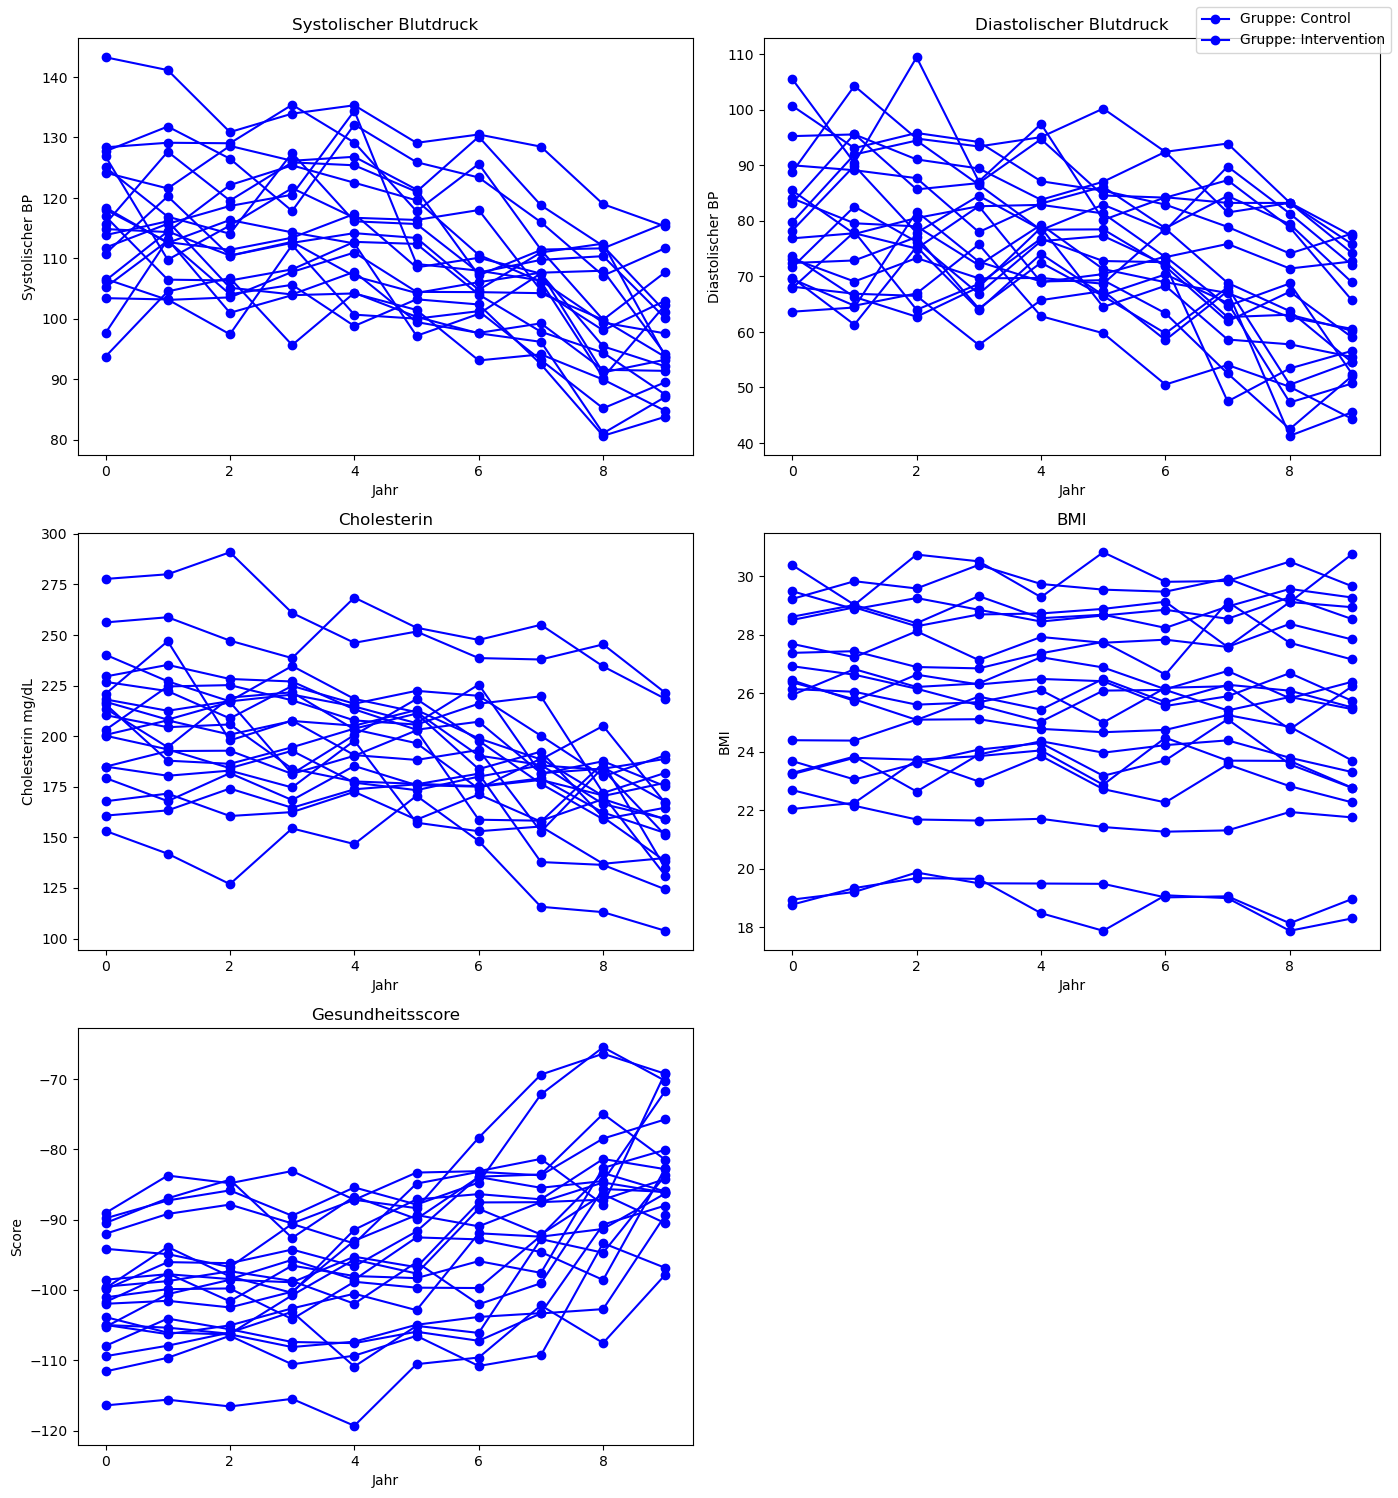

In [43]:
# choose 20 random patients
random_participants = np.random.choice(df['patient_id'].unique(), 20, replace=False)

# create plots for the chosen patients
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 plot

# Farben für die Gruppen definieren
colors = {'Intervention': 'blue', 'Control': 'red'}
group_labels_added = []

# Plotte für jede Metrik und füge nur einmal die Legende für jede Gruppe hinzu
for participant in random_participants:
    subset = df[df['patient_id'] == participant]
    group = subset['Group'].iloc[0]
    color = 'blue' #colors[group]
    label = f'Gruppe: {group}' if group not in group_labels_added else ""

    ax[0, 0].plot(subset['Year'], subset['Systolic_BP'], marker='o', color=color, label=label)
    ax[0, 1].plot(subset['Year'], subset['Diastolic_BP'], marker='o', color=color)
    ax[1, 0].plot(subset['Year'], subset['Cholesterol'], marker='o', color=color)
    ax[1, 1].plot(subset['Year'], subset['BMI'], marker='o', color=color)
    ax[2, 0].plot(subset['Year'], subset['Health_Score'], marker='o', color=color)

    if label:
        group_labels_added.append(group)

# set labels and titles
ax[0, 0].set_title('Systolischer Blutdruck')
ax[0, 0].set_xlabel('Jahr')
ax[0, 0].set_ylabel('Systolischer BP')
ax[0, 1].set_title('Diastolischer Blutdruck')
ax[0, 1].set_xlabel('Jahr')
ax[0, 1].set_ylabel('Diastolischer BP')
ax[1, 0].set_title('Cholesterin')
ax[1, 0].set_xlabel('Jahr')
ax[1, 0].set_ylabel('Cholesterin mg/dL')
ax[1, 1].set_title('BMI')
ax[1, 1].set_xlabel('Jahr')
ax[1, 1].set_ylabel('BMI')
ax[2, 0].set_title('Gesundheitsscore')
ax[2, 0].set_xlabel('Jahr')
ax[2, 0].set_ylabel('Score')


fig.legend(loc='upper right')
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

IndexError: invalid index to scalar variable.

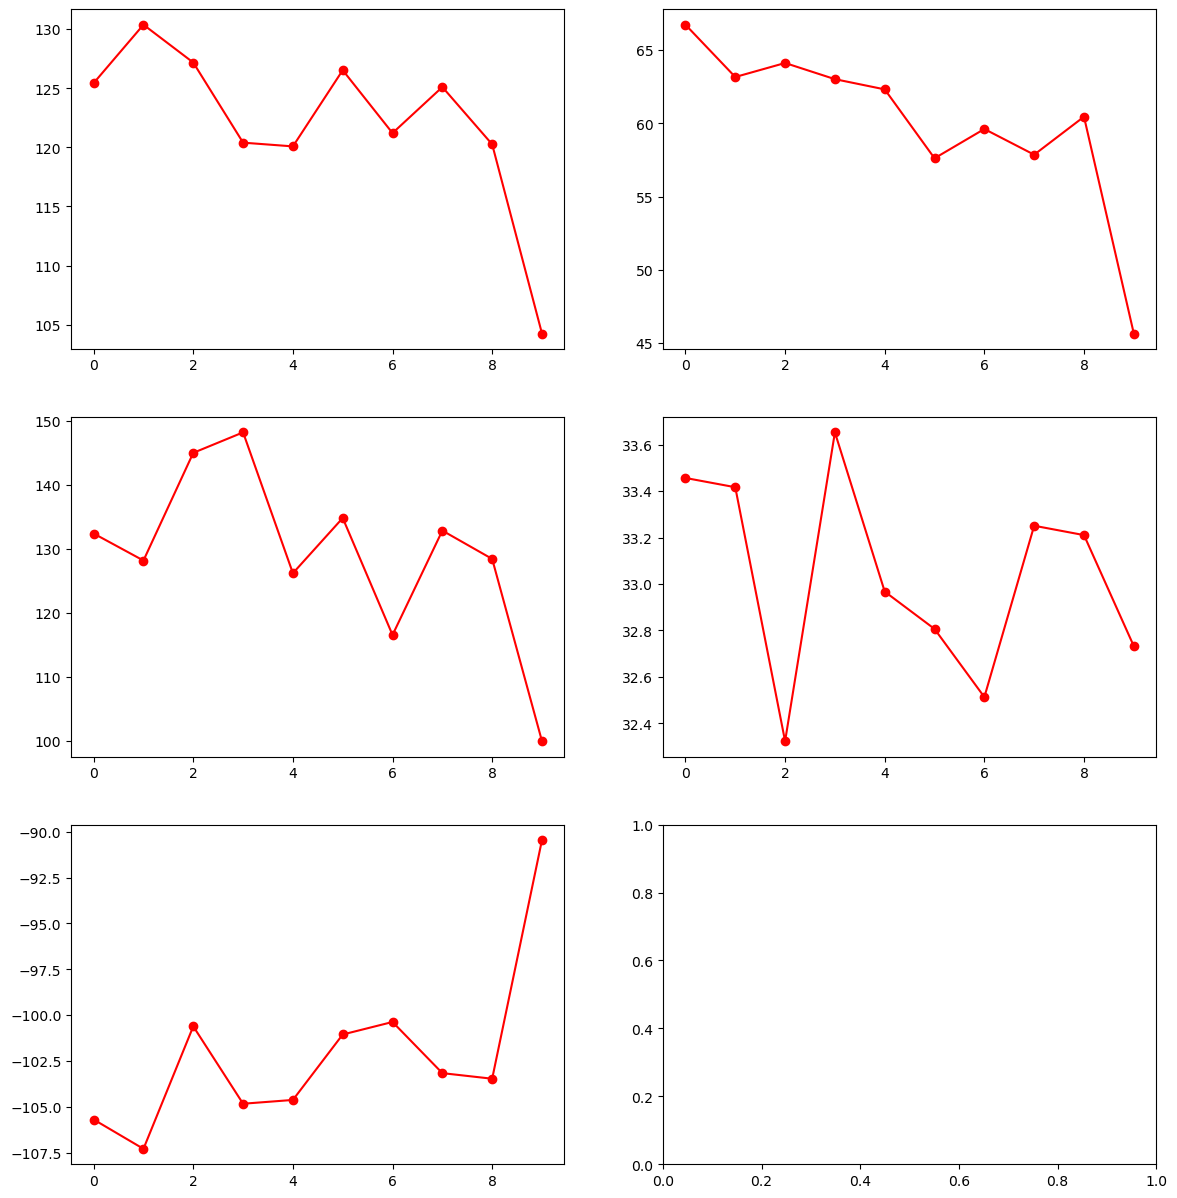

In [8]:
def update_color(get_treatment, line):
    if get_treatment == 1:
        line.set_color('green')
    else:
        line.set_color('red')
    plt.draw()
    plt.pause(1) 

# choose 20 random patients
random_participants = np.random.choice(df['patient_id'].unique(), 20, replace=False)

plt.ion()
# create plots for the chosen patients
fig, ax = plt.subplots(3, 2, figsize=(14, 15))  # 3x2 plot

# Plotte für jede Metrik und füge nur einmal die Legende für jede Gruppe hinzu
for participant in random_participants:
    subset = df[df['patient_id'] == participant]
    get_treatment = subset['Get_treatment'].iloc[0]

    line1, = ax[0, 0].plot(subset['Year'], subset['Systolic_BP'], marker='o', color = 'red')
    line2, = ax[0, 1].plot(subset['Year'], subset['Diastolic_BP'], marker='o', color = 'red')
    line3, = ax[1, 0].plot(subset['Year'], subset['Cholesterol'], marker='o', color = 'red')
    line4, = ax[1, 1].plot(subset['Year'], subset['BMI'], marker='o', color = 'red')
    line5, = ax[2, 0].plot(subset['Year'], subset['Health_Score'], marker='o', color = 'red')

    for i in range(10):
        update_color(get_treatment[i],line1)
        update_color(get_treatment[i],line2)
        update_color(get_treatment[i],line3)
        update_color(get_treatment[i],line4)
        update_color(get_treatment[i],line5)

# set labels and titles
ax[0, 0].set_title('Systolischer Blutdruck')
ax[0, 0].set_xlabel('Jahr')
ax[0, 0].set_ylabel('Systolischer BP')
ax[0, 1].set_title('Diastolischer Blutdruck')
ax[0, 1].set_xlabel('Jahr')
ax[0, 1].set_ylabel('Diastolischer BP')
ax[1, 0].set_title('Cholesterin')
ax[1, 0].set_xlabel('Jahr')
ax[1, 0].set_ylabel('Cholesterin mg/dL')
ax[1, 1].set_title('BMI')
ax[1, 1].set_xlabel('Jahr')
ax[1, 1].set_ylabel('BMI')
ax[2, 0].set_title('Gesundheitsscore')
ax[2, 0].set_xlabel('Jahr')
ax[2, 0].set_ylabel('Score')


fig.legend(loc='upper right')
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# return index of first occur of 'pat' in collumn patient_id
def get_ind(pat, df):
    return np.where(df['patient_id'] == pat)[0]

# returns a block diagonal matrix of a list of matrices
def block_diag_list(arrs_list):
    shape = torch.sum(torch.tensor([a.shape for a in arrs_list], dtype=torch.int32), dim=0)
    dtype = arrs_list[0].dtype
    device = arrs_list[0].device

    out = torch.zeros(*shape.tolist(), dtype=dtype, device=device)

    r, c = 0, 0
    for a in arrs_list:
        rows, cols = a.shape
        out[r:r + rows, c:c + cols] = a
        r += rows
        c += cols
    return out

# Random effects design matrix (Datenmatrix) for each patient
def calculate_Zlist(df, random_effects_keys):
    Z_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), random_effects_keys]))
                        ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return Z_list

# Fixed effects design matrix (Datenmatrix) for each patient
def calculate_Xlist(df, fixed_effects_keys):
    X_list = [torch.cat((
        torch.ones(len(get_ind(pat, df)), 1), 
        torch.from_numpy(np.array(df.loc[get_ind(pat, df), fixed_effects_keys]))
                         ), -1).to(torch.float32)
                for pat in df['patient_id'].unique()]
    return X_list

def likelihood_ratio(Lmin, Lmax, diff):
    return  2 * (Lmax - Lmin)

In [11]:
num_simulations = 5
#keys for random and fixed effects in the matrix
fixed_effects_keys = ['Age', 'Gender', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI', 'Creatinin', 'Get_treatment']
random_effects_keys = []
#keys for random and fixed effects in the matrix
fixed_effects_keys_r = ['Age', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol', 'Triglycerides', 'BMI','Creatinin', 'Get_treatment']
random_effects_keys_r = []

n_fixed_eff = len(fixed_effects_keys) + 1
n_rand_eff = len(random_effects_keys) + 1
n_fixed_eff_r = len(fixed_effects_keys_r) + 1
n_rand_eff_r = len(random_effects_keys_r) + 1
softplus = torch.nn.Softplus()
D_param = torch.randn(n_rand_eff, requires_grad=True) # Learnable parameter for diagonal covariance matrix
D_param_r = torch.randn(n_rand_eff_r, requires_grad=True) # Learnable parameter for diagonal covariance matrix
lrt_results = []

for _ in range(num_simulations):
    data = pd.DataFrame(simulate_data(200), columns=['patient_id', 'Year', 'Age', 'Group', 'Gender', 'Get_treatment', 'Systolic_BP', 'Diastolic_BP', 
                                                  'Cholesterol', 'Triglycerides', 'BMI','Creatinin', 'Health_Score'])
    N = len(data)
    Z_list = calculate_Zlist(data, random_effects_keys) # Random effects design matrix (Datenmatrix) for each patient
    X_list = calculate_Xlist(data, fixed_effects_keys) # Fixed effects design matrix (Datenmatrix) for each patient
    y = torch.from_numpy(np.array(data['Health_Score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list = [torch.cat((X_i, torch.zeros((n_rand_eff, n_fixed_eff)))) for X_i in X_list] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e = torch.cat([torch.cat((y[get_ind(pat,data)], torch.zeros(n_rand_eff))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_full(D_param): 
        # Ensure that the diagonal covariance matrix has only positive values
        Delta = torch.diag(softplus(D_param))
        det_Delta = torch.det(Delta)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list = [torch.cat((Z_i, Delta)) for Z_i in Z_list]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e = torch.cat((block_diag_list(Z_tilde_list), torch.cat(X_tilde_list)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred = torch.inverse((X_e.t() @ X_e)) @ X_e.t() @ y_e
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma = torch.sum((y_e - X_e @ pred) ** 2) / N

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma))
        likelihood += torch.log(torch.stack([det_Delta/torch.det(Z_i_tilde.t() @ Z_i_tilde).sqrt() for Z_i_tilde in Z_tilde_list])).sum()
        return - likelihood
    
    result_full = minimize(calculate_likelihood_full, D_param, method='bfgs', max_iter=6)
    Lmax = result_full.fun

    N_r = len(data)
    Z_list_r = calculate_Zlist(data, random_effects_keys_r) # Random effects design matrix (Datenmatrix) for each patient
    X_list_r = calculate_Xlist(data, fixed_effects_keys_r) # Fixed effects design matrix (Datenmatrix) for each patient
    y_r = torch.from_numpy(np.array(data['Health_Score'])).to(torch.float32) # Response variable: Test scores
    X_tilde_list_r = [torch.cat((X_i, torch.zeros((n_rand_eff_r, n_fixed_eff_r)))) for X_i in X_list_r] # Defining list of X tilde (eq. 2.7 p. 63)
    y_e_r = torch.cat([torch.cat((y_r[get_ind(pat,data)], torch.zeros(n_rand_eff_r))).unsqueeze(-1) for pat in data['patient_id'].unique()]) # Augmented response vector y_e (eq. 2.11 p. 65)

    def calculate_likelihood_reduced(D_param_r):
        # Ensure that the diagonal covariance matrix has only positive values
        Delta_r = torch.diag(softplus(D_param_r))
        det_Delta_r = torch.det(Delta_r)  

        # Defining list of Z tilde (eq. 2.7 p. 63)
        Z_tilde_list_r = [torch.cat((Z_i, Delta_r)) for Z_i in Z_list_r]
        # Matrix X_e (eq. 2.11 p. 65)
        X_e_r = torch.cat((block_diag_list(Z_tilde_list_r), torch.cat(X_tilde_list_r)), -1)

        # Calculate MLE estimates of random and fixed effects with current set of covariance Parameters (eq. 2.11 p. 65)
        pred_r = torch.inverse((X_e_r.t() @ X_e_r)) @ X_e_r.t() @ y_e_r
        # Calculate MLE estimates of the noise sigma with current set of covariance Parameters (eq. 2.12 p. 65)
        pred_sigma_r = torch.sum((y_e_r - X_e_r @ pred_r) ** 2) / N_r

        # Calculate the logarithm of the likelihood function in (eq. 2.13 p. 65)
        likelihood = -N_r/2 * (1 + torch.log(torch.tensor(2 * torch.pi)) + torch.log(pred_sigma_r))
        likelihood += torch.log(torch.stack([det_Delta_r/torch.det(Z_i_tilde_r.t() @ Z_i_tilde_r).sqrt() for Z_i_tilde_r in Z_tilde_list_r])).sum()
        return - likelihood
    result_reduced = minimize(calculate_likelihood_reduced, D_param_r, method='bfgs', max_iter=6)
    Lmin = result_reduced.fun

    lrt_results.append(likelihood_ratio(Lmin,Lmax,1))
    print(i)

0
0
0
0
0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


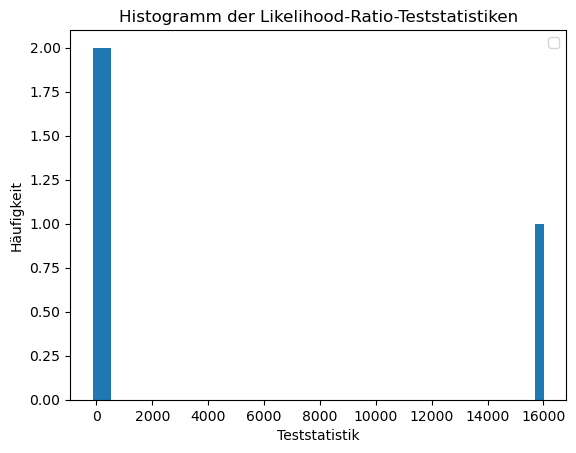

In [15]:
# Histogramm der Teststatistiken erstellen
plt.hist(lrt_results, bins=50) # balken dünner und so dass man mit chi quadrat vergleichen kann

# Chi-Quadrat-Verteilung mit einem Freiheitsgrad plotten (für Vergleich)
#x = np.linspace(0, 10, 1000)
#plt.plot(-x, chi2.pdf(x, df=1), 'r-', lw=1, label='Chi-Squared (df=1)')

# Beschriftungen hinzufügen
plt.title('Histogramm der Likelihood-Ratio-Teststatistiken')
plt.xlabel('Teststatistik')
plt.ylabel('Häufigkeit')
plt.legend()

# Histogramm anzeigen
plt.show()